In [1]:
import logging

import httpimport
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import ILSVRC2014Sample, to_np, to_tensor, CUDA, VGG, load_image

logging.getLogger("PIL").setLevel(logging.INFO)


with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    import common.plotting


In [2]:
![ -e ../data/ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ../data/ilsvrc_subsample.tar.bz2
![ -d ../data/ilsvrc_subsample ] || tar -jxf ../data/ilsvrc_subsample.tar.bz2 -C ../data

In [3]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

In [4]:
ilsvrc = ILSVRC2014Sample(40)

In [5]:
def obscured_imgs(img, boxsize=8, bsz=64, stride=4):
    batch = []
    for i in range(0, img.shape[0] - boxsize + 1, stride):
        for j in range(0, img.shape[1] - boxsize + 1, stride):
            img_copy = np.copy(img)
            img_copy[..., i:i+boxsize, j:j+boxsize, :] = np.array([0.485, 0.456, 0.406])
            batch.append(img_copy)
            if len(batch) == bsz:
                yield np.stack(batch)
                batch = []
    yield np.stack(batch)

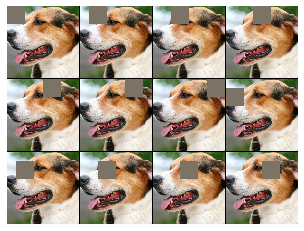

In [6]:
# Show samples from an obscured batch
batch = next(obscured_imgs(ilsvrc.data[27], boxsize=56, bsz=12, stride=28))
batch = np.vstack([im[None] for im in batch])

common.plotting.plot_mat(batch.transpose(0, 3, 1, 2))

In [7]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [8]:
idx = 32
img = ilsvrc.data[idx]
label = ilsvrc.labels[idx]

# if you run out of GPU mem split batch into smaller ones
bsz = 32
boxsize = 52
stride = 14

vgg.eval()

# Accumulate activations for activation heatmap,
# true class probability map, network prediction map
map_types = ["heat", "prob", "pred"]
maps = {mt: [] for mt in map_types}
for batch in obscured_imgs(img, boxsize, bsz, stride):
    with torch.no_grad():
        batch = to_tensor(batch)
        # TODO choose a layer and a neuron. Aggregate its activations across all locations in the image
        # The sample code used layer conv2_1 and neuron #1
        maps["heat"].append(to_np(vgg.layer_activations(batch, "conv2_1"))[:, 1].sum(axis=(1, 2)))
        maps["prob"].append(to_np(vgg.probabilities(batch))[:, ilsvrc.label_to_id[label]])
        maps['pred'].append(to_np(vgg.predict(batch)))

for k in maps:
    maps[k] = np.concatenate(maps[k])
    maps[k] = maps[k].reshape(int(np.sqrt(maps[k].shape[0])), -1)

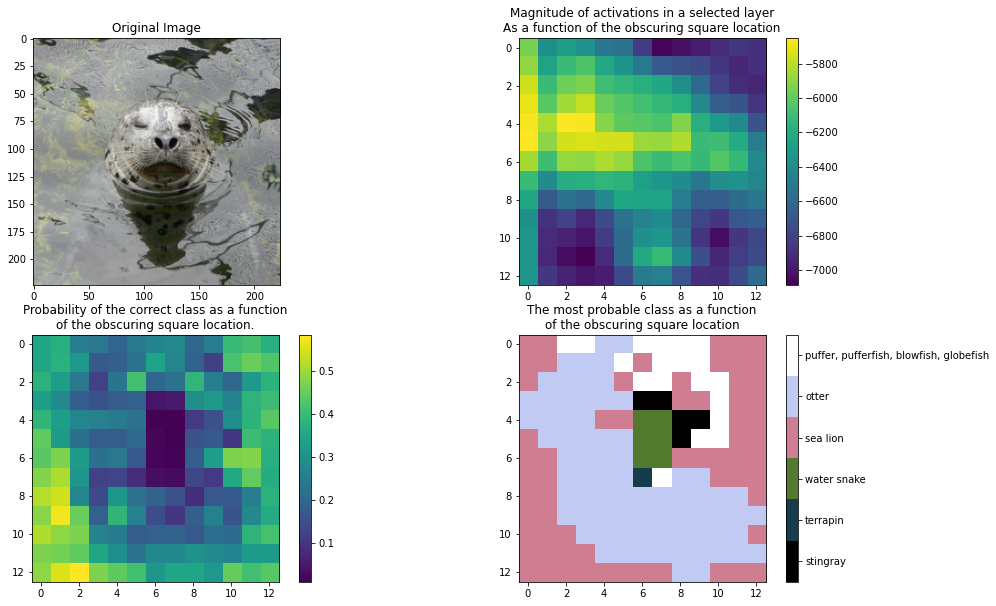

In [9]:
#
# This image recreates figure 7 from M. Zieler et al.
# Visualizing and Understanding Convolutional Neural Networks
# https://arxiv.org/pdf/1311.2901.pdf
#

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.grid(False)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(maps["heat"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Magnitude of activations in a selected layer\n"
    "As a function of the obscuring square location"
)

plt.subplot(2, 2, 3)
plt.imshow(maps["prob"], cmap="viridis")
plt.grid(False)
plt.colorbar()
plt.title(
    "Probability of the correct class as a function\n"
    "of the obscuring square location."
)

plt.subplot(2, 2, 4)
discrete = np.zeros_like(maps["pred"], dtype=np.int64)
values = np.unique(maps["pred"]).astype(np.int64)
for i, v in enumerate(values):
    discrete[np.where(maps["pred"] == v)] = i
num_values = max(values.shape[0], 1)
plt.imshow(discrete, cmap=discrete_cmap(num_values, "cubehelix"))
plt.grid(False)
cb = plt.colorbar(
    ticks=np.arange(
        (num_values - 1.0) / num_values / 2.0,
        num_values,
        (num_values - 1.0) / num_values,
    )
)
cb.set_ticks(
    np.arange(0.5 - 0.5/num_values, num_values - 1, 1 - 1/num_values),
    labels=[ilsvrc.id_to_desc[v] for v in values],
)
plt.title("The most probable class as a function\n" "of the obscuring square location")
plt.show()